In [30]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import einops
import math

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

Using device: mps


In [2]:
names = list((open('data/names/names.txt', 'r').read().splitlines()))

chars = sorted(set(''.join(names)))
char_to_idx = {s: i for i, s in enumerate(['.'] + chars)}
index_to_char = {i: s for s, i in char_to_idx.items()}

names[:5], chars[:5]

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], ['a', 'b', 'c', 'd', 'e'])

In [3]:
char_to_idx['a'], char_to_idx['b'], char_to_idx['c'], char_to_idx['d'], char_to_idx['e']

(1, 2, 3, 4, 5)

In [4]:
index_to_char[0], index_to_char[1], index_to_char[2], index_to_char[3], index_to_char[4]

('.', 'a', 'b', 'c', 'd')

In [6]:
xs, ys = [], []
context_size = 8
for name in names:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        context = context[1:] + [idx]

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146, 8]), torch.Size([228146]))

In [7]:
train_size = int(0.8 * len(xs))
dev_size = int(0.1 * len(xs))
test_size = len(xs) - train_size - dev_size
train_size, dev_size, test_size, train_size + dev_size + test_size

idxs_in_random_order = torch.randperm(len(xs))
train_idxs = idxs_in_random_order[:train_size]
dev_idxs = idxs_in_random_order[train_size:train_size + dev_size]
test_idxs = idxs_in_random_order[train_size + dev_size:]

train_xs, train_ys = xs[train_idxs], ys[train_idxs]
dev_xs, dev_ys = xs[dev_idxs], ys[dev_idxs]
test_xs, test_ys = xs[test_idxs], ys[test_idxs]

train_xs.shape, train_ys.shape, dev_xs.shape, dev_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([182516, 8]),
 torch.Size([182516]),
 torch.Size([22814, 8]),
 torch.Size([22814]),
 torch.Size([22816, 8]),
 torch.Size([22816]))

In [84]:
C = torch.randn((27, 100), generator=g)
x = C[train_xs[:4]]
w = torch.randn((200, 100), generator=g)
print(x.shape, w.shape)
# (x.view(-1, context_size // 2, 100 * 2) @ w).shape
x = einops.rearrange(
    x, "batch (ctxt_split n_splits) embed -> batch ctxt_split (n_splits embed)",
    ctxt_split=context_size // 2, n_splits=2
)
print(x.shape)
out = einops.einsum(
    x, w,
    "batch merged_words in, in out -> batch merged_words out"
)
print(out.shape)
batch_mean = x.mean(dim=(0, 1), keepdim=True)
batch_var = x.var(dim=(0, 1), keepdim=True)
x_norm = (x - batch_mean) / torch.sqrt(batch_var + 1e-5)
print(batch_mean.shape, batch_var.shape, x_norm.shape)

torch.Size([4, 8, 100]) torch.Size([200, 100])
torch.Size([4, 4, 200])
torch.Size([4, 4, 100])
torch.Size([1, 1, 200]) torch.Size([1, 1, 200]) torch.Size([4, 4, 200])


In [170]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.b = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        # self.out = einops.einsum(
        #     x, self.W, 
        #     "batch ngrams in" # For 3-d input tensor
        #     "batch in" # For 2-d input tensor
        #     , in out -> batch ngrams out"
        # )
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


In [176]:
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self.training = True
    
    def __call__(self, x):
        dim = 0 if x.ndim == 2 else (0, 1)
        batch_mean = x.mean(dim=dim, keepdim=True) if self.training else self.running_mean
        batch_var = x.var(dim=dim, keepdim=True) if self.training else self.running_var
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean.squeeze(1)
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var.squeeze(1)
        x_norm = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.gamma * x_norm + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [178]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.embeddings = torch.randn((num_embeddings, embedding_dim), generator=g)
    
    def __call__(self, x):
        embeds = self.embeddings[x]
        return embeds
    
    def parameters(self):
        return [self.embeddings]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        self.out = einops.rearrange(
            x, "batch (ctxt_split n) embed -> batch ctxt_split (n embed)",
            ctxt_split=x.shape[1] // self.n, n=self.n
        )
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out
    
    def parameters(self):
        return []

In [179]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [180]:
class Sequential:
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size, n=2):
        self.layers = [
            Embedding(vocab_size, embedding_dim),
            FlattenConsecutive(n=n), Linear(n * embedding_dim, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            FlattenConsecutive(n=n), Linear(n * hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            FlattenConsecutive(n=n), Linear(n * hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, vocab_size, bias=False), BatchNorm1d(vocab_size)
        ]
        self.__post_init__()
    
    def __post_init__(self):
        self.layers[-1].gamma *= 0.1
        for l in self.layers[:-1]:
            if isinstance(l, Linear):
                l.W *= 5/3
    
    def __call__(self, x):
        out = x
        for l in self.layers:
            out = l(out)
        return out
        
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [181]:
vocab_size = 27
embedding_dim = 10
context_size = 8
hidden_size = 68
model = Sequential(vocab_size, embedding_dim, context_size, hidden_size)

print(sum(p.numel() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


22424


In [ ]:
epochs = 200000
batch_size = 32
losses = []
update_to_data_ratio = []
for i in range(epochs):
    idxs = torch.randint(0, train_xs.shape[0], (batch_size, ), generator=g)
    logits = model(train_xs[idxs])
    loss = F.cross_entropy(logits, train_ys[idxs])

    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i=}/{epochs}, {loss.item()=}")
    
    with torch.no_grad():
        update_to_data_ratio.append([
            (lr * p.grad.std() / p.data.std()).log10().item() 
            for p in model.parameters()
        ])
    # if i > 1000:    
    #     break

i=0/200000, loss.item()=2.346043109893799
i=10000/200000, loss.item()=2.00773024559021
i=20000/200000, loss.item()=2.137181520462036
i=30000/200000, loss.item()=2.0259432792663574
i=40000/200000, loss.item()=2.1181294918060303
i=50000/200000, loss.item()=2.0501835346221924
i=60000/200000, loss.item()=1.7826497554779053
i=70000/200000, loss.item()=1.9870392084121704
i=80000/200000, loss.item()=1.8916015625
i=90000/200000, loss.item()=2.4261088371276855
i=100000/200000, loss.item()=2.1046555042266846
i=110000/200000, loss.item()=1.6911033391952515
i=120000/200000, loss.item()=2.0438597202301025
i=130000/200000, loss.item()=1.7026625871658325
i=140000/200000, loss.item()=2.4187140464782715


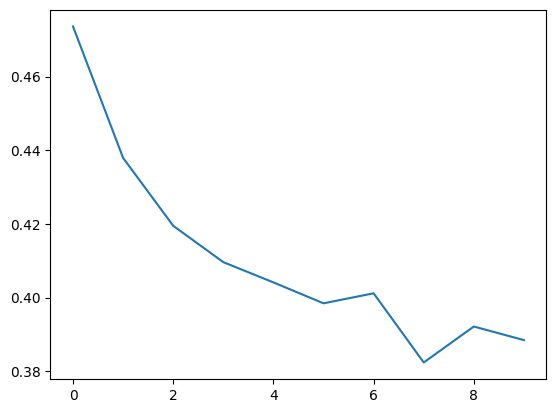

In [ ]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(dim=1))

In [35]:
@torch.no_grad()  # avoids gradient bookeeping for backward pass
def split_loss(split_name: str):
    x, y = {
        "train": (train_xs, train_ys),
        "dev": (dev_xs, dev_ys),
        "test": (test_xs, test_ys)
    }[split_name]
    for l in model.layers:
        if isinstance(l, BatchNorm1d):
            l.training = False
    logits = model(x)
    loss = F.cross_entropy(logits, y).item()
    print(f"{split_name=}, {loss=}")

split_loss("train")
split_loss("dev")

split_name='train', loss=2.0138068199157715
split_name='dev', loss=2.0814733505249023


In [36]:
for _ in range(20):
    name = ""
    context = [0] * context_size
    while True:
        logits = model(torch.tensor(context).unsqueeze(0))
        probs = logits.softmax(dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        next_char = index_to_char[idx]
        name += next_char
        if next_char == ".":
            break
    print(name)


kesea.
clazia.
kmiratel.
aparmina.
jaylara.
jerram.
ganatal.
iana.
yeliz.
mirson.
myroston.
aryz.
jelison.
weani.
grancy.
feldon.
meeri.
mecilio.
vaynee.
shavier.
